In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# import warnings module
import warnings
warnings.filterwarnings("ignore")

# **PROBLEM STATEMENT**

BoomBikes, a US bike-sharing provider, faces revenue challenges due to the COVID-19 pandemic and seeks to analyze bike-sharing demand patterns for post-pandemic recovery. The company aims to identify key factors influencing bike rental demand to optimize their business strategy and gain competitive advantage. The goal is to build a predictive model that:

*   Which variables are significant in predicting the demand for shared bikes.
*   How well those variables describe the bike demands



# **Step 1: Reading, Understanding and Visualizing the Data**

In [4]:
#Read the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/bike.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
df.shape

(730, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# **Summary:**

*   The dataset has 730 data with 16 columns.
*   There is no missing values.
*   Target variable 'cnt' properly formated
*   Redundant data:
  *   Index column "instant" is not useful for analysis
  *   The dteday is redundant data as well because we already have mth, yr, and weekday data.
  *   cnt = registered + casual, for the problem to predict the overall demand 'cnt', registered and casual users are not necessary. Keep them lead to multicollinearity in prediction model
*   Categorical data: season, mnth, weekday, weathersit represented with numerical values may make the model assume a meaningful numerical relationship between these categories which does not exist. We should convert into string values.
*   Binary data: holiday, working day, yr is formated properly
*   Numerical data: temp, atemp, hum, windspeed needs to be scaled even though the ranges are slightly different.


# **Step 2: Preparing the data for modelling**

## **Data cleaning & encoding**

**Drop unncessary data**

In [8]:
# Drop instant and dteday, casual and registered users
df.drop(['instant','dteday','casual','registered'], axis = 1, inplace=True)

In [9]:
# Check the data after dropping
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


**Converting norminal categorical data into string values to prevent misintepretation of the data ordering**

In [10]:
# season (1:spring, 2:summer, 3:fall, 4:winter)
df.season = df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df.season.value_counts()

,count
season,
fall,188
summer,184
spring,180
winter,178


In [11]:
# weathersit :
		#- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		#- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		#- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		#- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
df.weathersit = df.weathersit.map({1:'Clear', 2:'Mist', 3:'Light Rain', 4:'Heavy Rain'})
df.weathersit.value_counts()

,count
weathersit,
Clear,463
Mist,246
Light Rain,21


In [12]:
# mnth : month ( 1 to 12)
df.mnth = df.mnth.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
df.mnth.value_counts()

,count
mnth,
Jan,62
Mar,62
May,62
Jul,62
Aug,62
Oct,62
Dec,62
Apr,60
Jun,60


In [13]:
 #weekday : day of the week
df.weekday = df.weekday.map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'})
df.weekday.value_counts()

,count
weekday,
Mon,105
Tue,105
Wed,104
Thu,104
Fri,104
Sat,104
Sun,104


## **Visualizing the data**

In [14]:
# Check columns of the data set
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [15]:
# List of numerical columns
df_num = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# List of categorical columns
df_cat = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit']

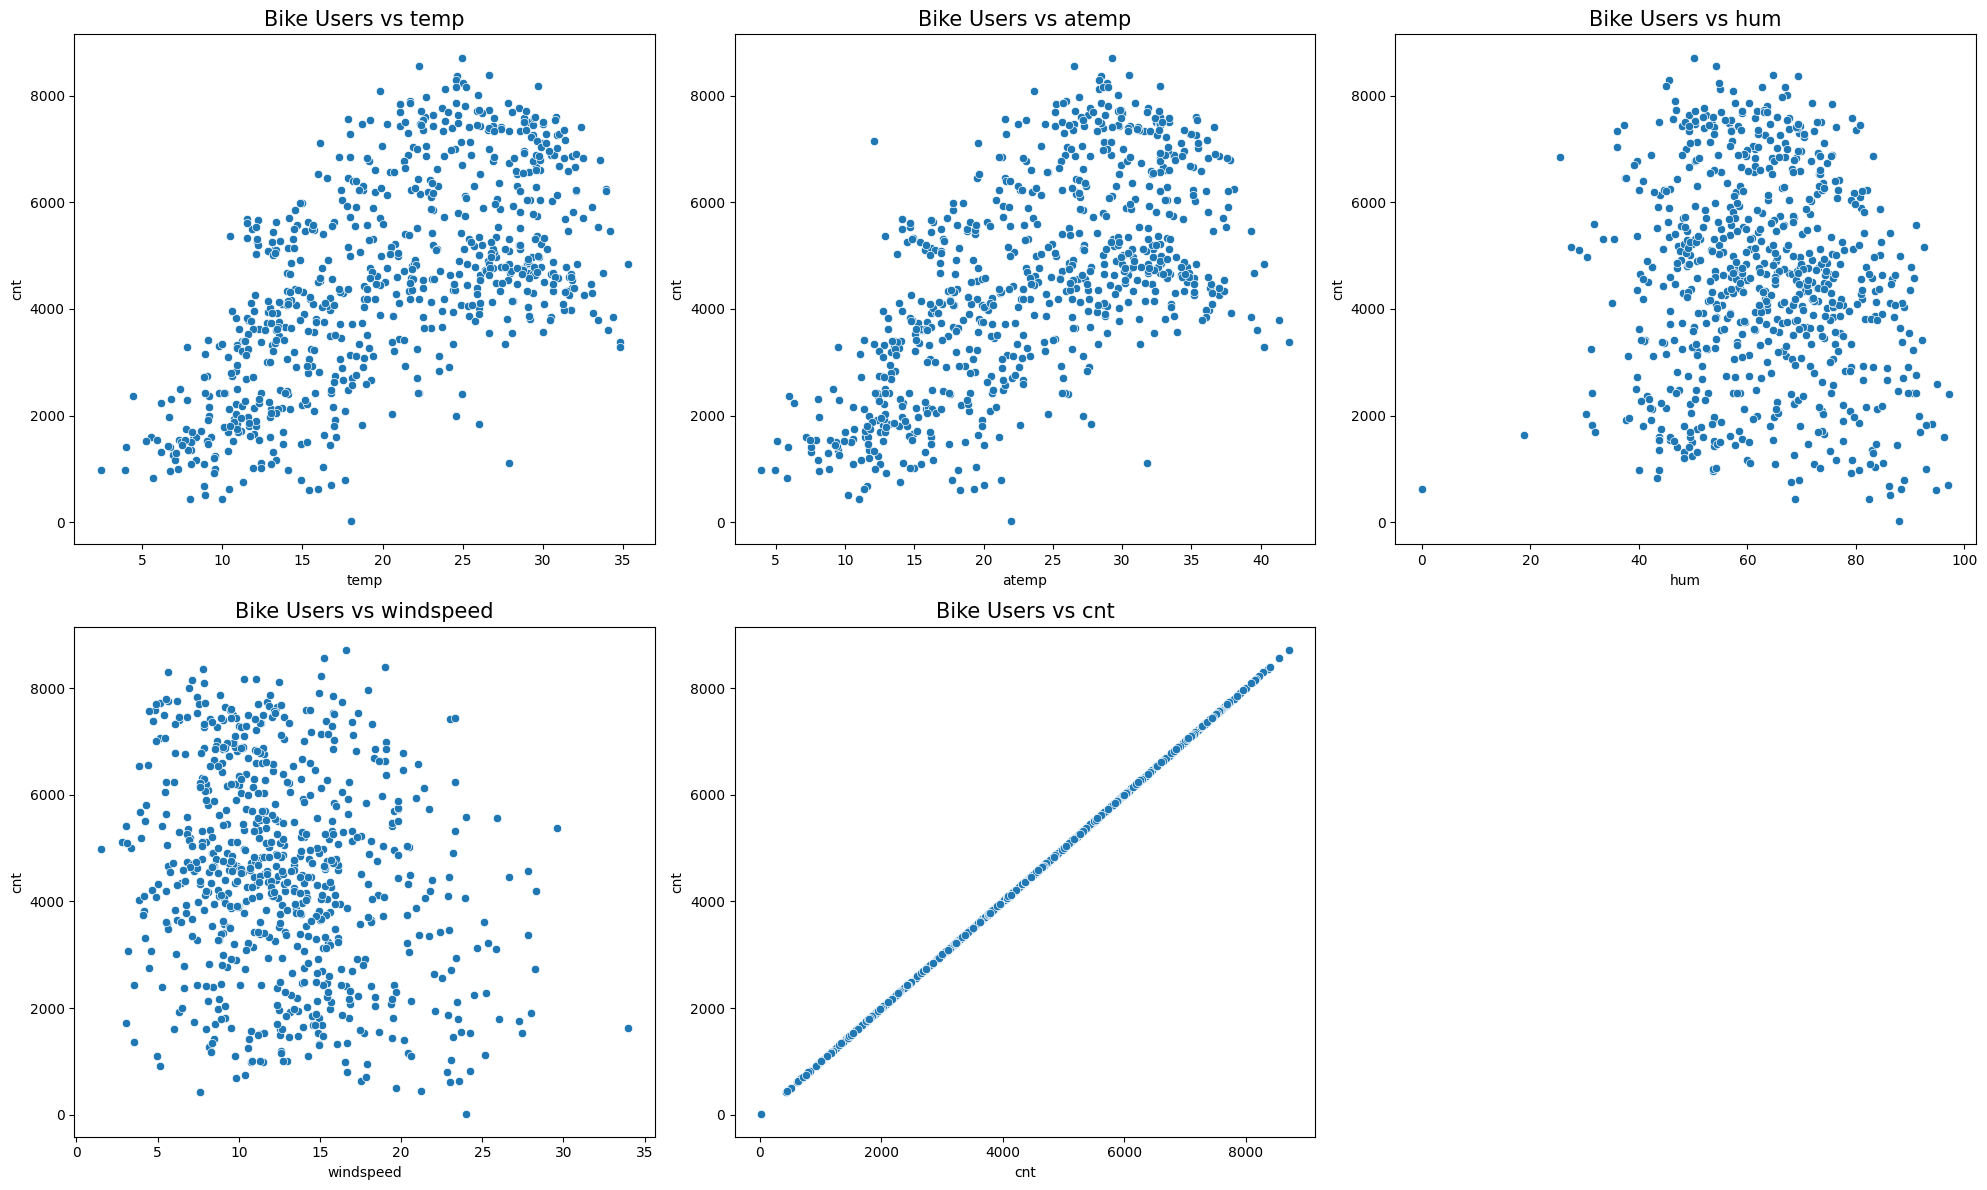

In [16]:
# Using scatterplot to check relationship of numerical data with the target variable
plt.figure(figsize=(20, 12))
for index, col in enumerate(df_num, 1):
    plt.subplot(2,3,index)
    sns.scatterplot(data=df, x =col, y ='cnt')
    plt.title(f'Bike Users vs {col}', fontsize=15)
plt.tight_layout()
plt.show()

**Insights:**

---


* Temp and atemp show a strong positive correlation with bike usage while humidity and wind speed have a weak correllation due to a very scatterd pattern

**This suggests that we can apply the linear regression to predict the bike users as the linear relationship exists, potentially temp/atemp are strong predictors. In term of business, more bike rentals occur in warmer temperatures**

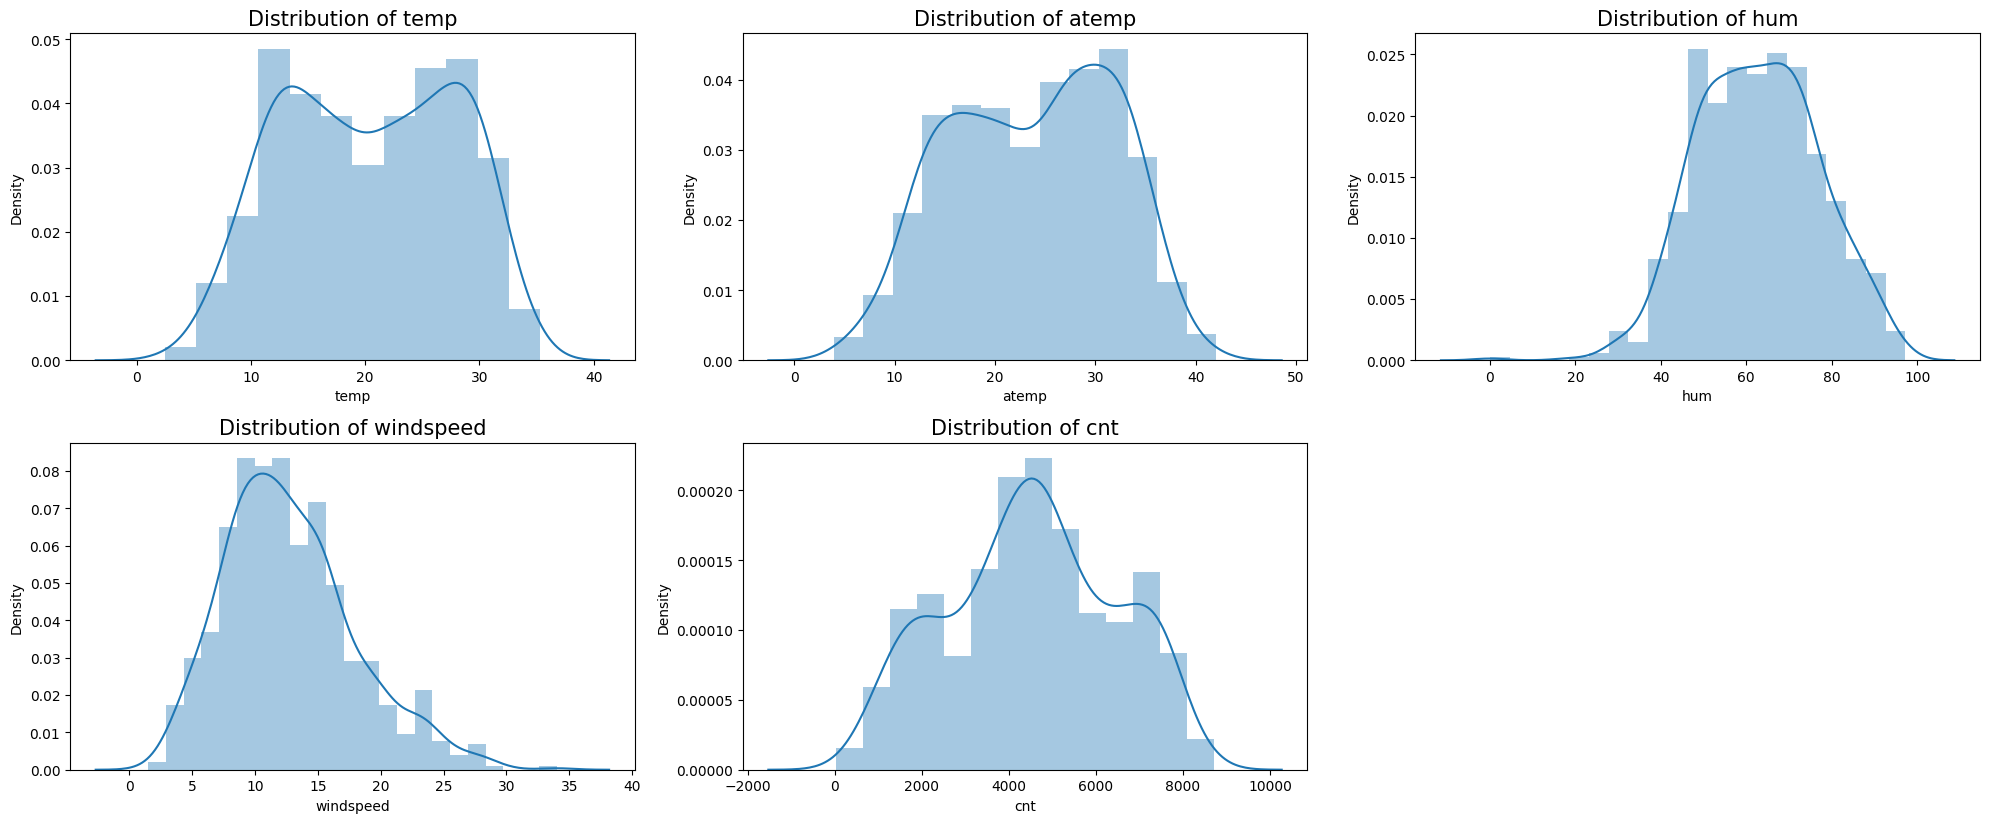

In [17]:
# Using histogram to check the distribution of numerical data
plt.figure(figsize=(20, 12))
for index, col in enumerate(df_num, 1):
    plt.subplot(3,3,index)
    sns.distplot(df[col])
    plt.title(f'Distribution of {col}', fontsize=15)
plt.tight_layout()
plt.show()

**Insights:**

---


* Tempt and atempt shows a bimodal distribution with 2 peaks around 15 and 30C degree, underlying a seasonal pattern
* Humidity, windspeeds and bike users shows a normal bell-curved distribution

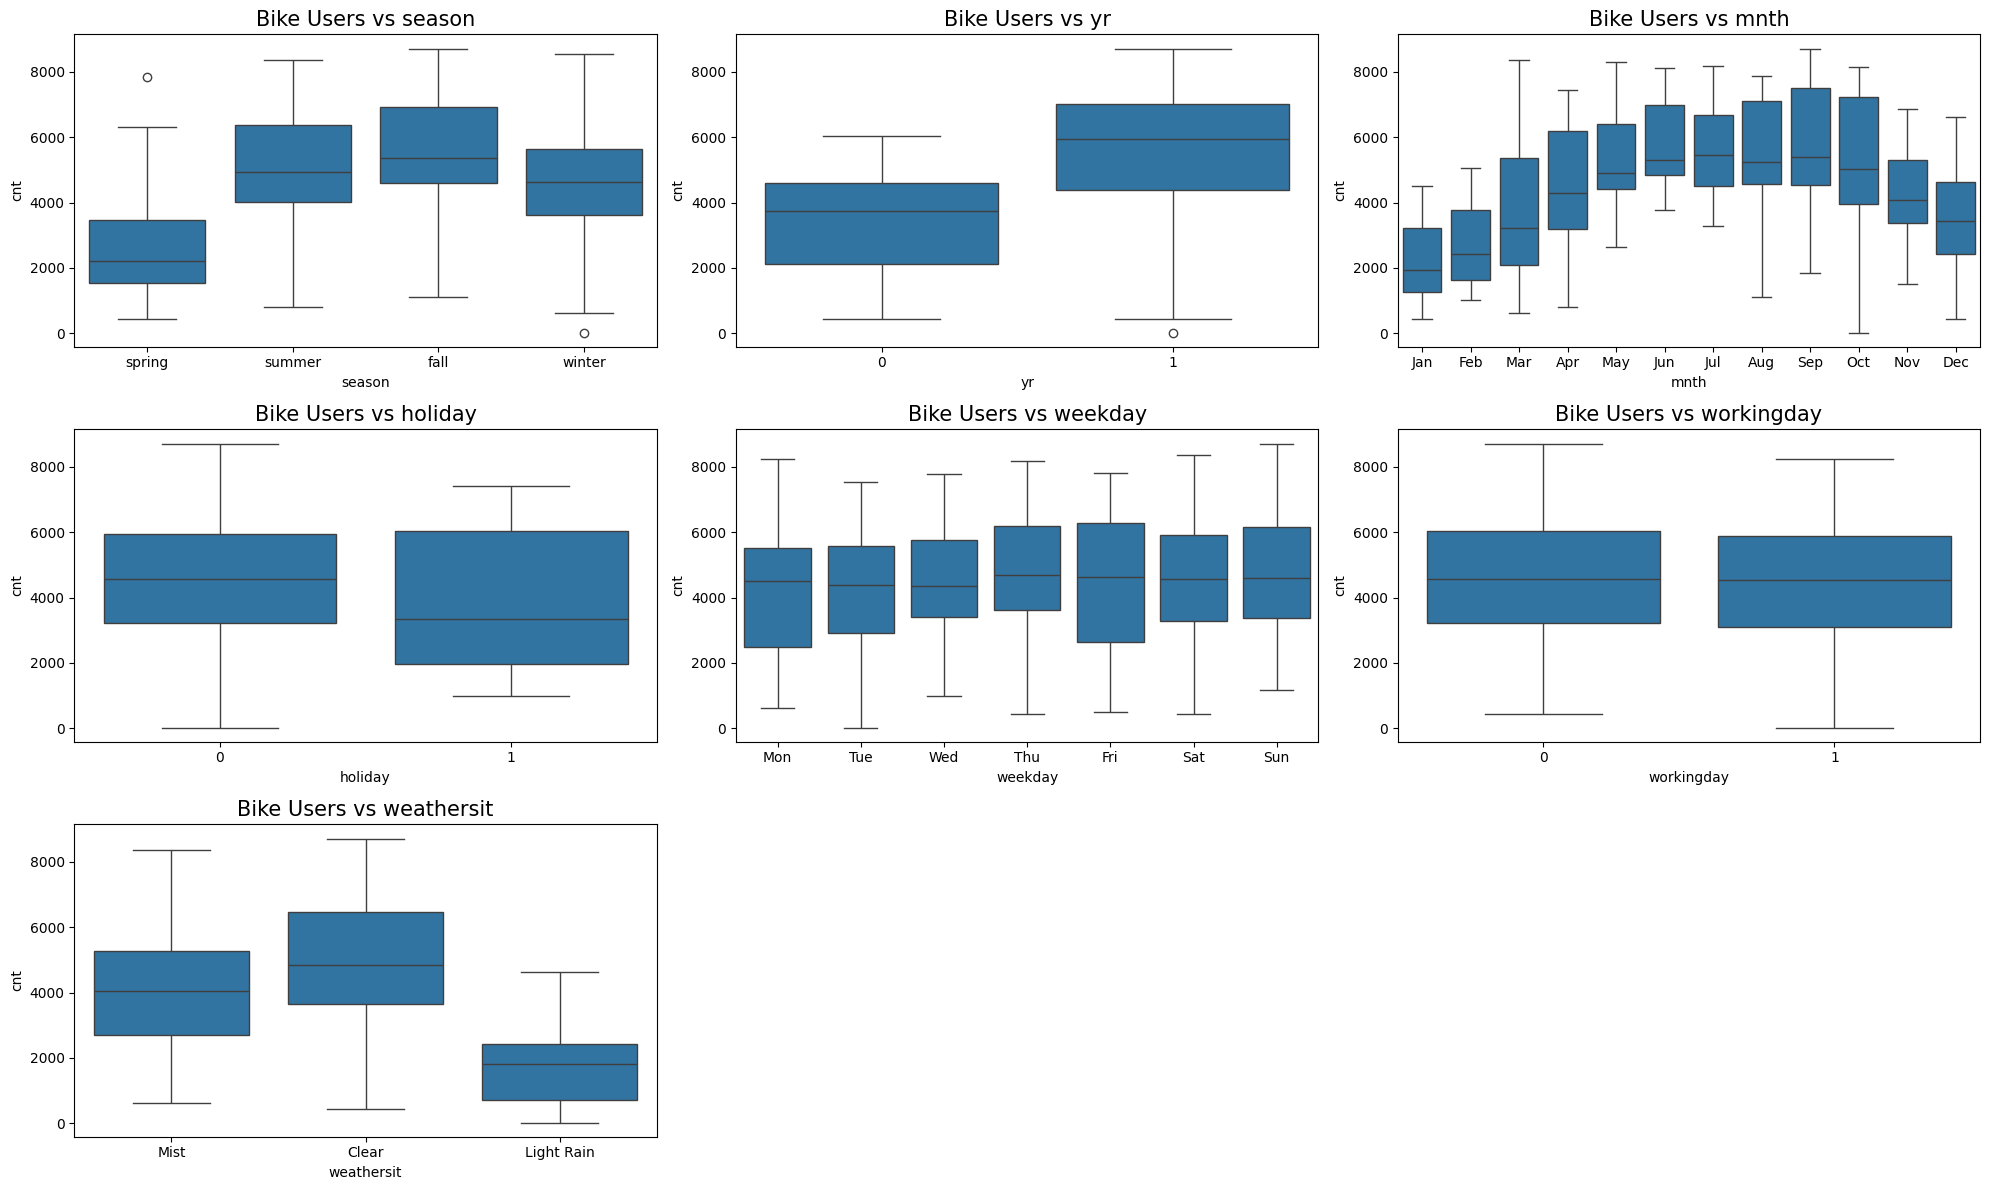

In [18]:
# Using boxplot to check the relationship of categorical data with the target variables
plt.figure(figsize=(20, 12))
for index, col in enumerate(df_cat, 1):
    plt.subplot(3,3,index)
    sns.boxplot(data=df, x =col, y ='cnt')
    plt.title(f'Bike Users vs {col}', fontsize=15)
plt.tight_layout()
plt.show()

**Insights:**

---


* Season: clear seasonal pattern with highest rental in summer and fall
* Year: 2018 (yr=1) shows a higher rental, proving a growing adoption of the service
* Month: a sinusoidal (wave-like) pattern with the peak in summer and a drop in spring
* Holiday: slighly wider spread on holidays (holiday = 1). It seems that holiday has more variability on bike demands while non-holidays has a more consistent rental patterns. This can be explained by the different types of holidays, events and activities impact on the bike usage behavior.
* Weekday: relatively consistent over the weekdays suggest a steady commuter usage. Variability during weekends.
* Workingday: very similar pattern suggest that the working schedule may not influence the bike usage.
* Weather condition: shows a highest rental demand during clear weather while light rain shows a lowest rental. There are not data for "heavy rain" category, probably users will avoid cycling in heavy rain.

**Looking at the variation of box plots, we can suggest that season, weather, yearly growth and month are the strongest categorical predictors of bike rentals while others have less impact. Holiday, weekday and working day show some influence, however mainly in terms of variability rather than the overall rental demand**

## **Check correllation and multicollinearity**

In [19]:
# Create correllation matrix of numerical variables
corr = df[df_num].corr()
corr

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


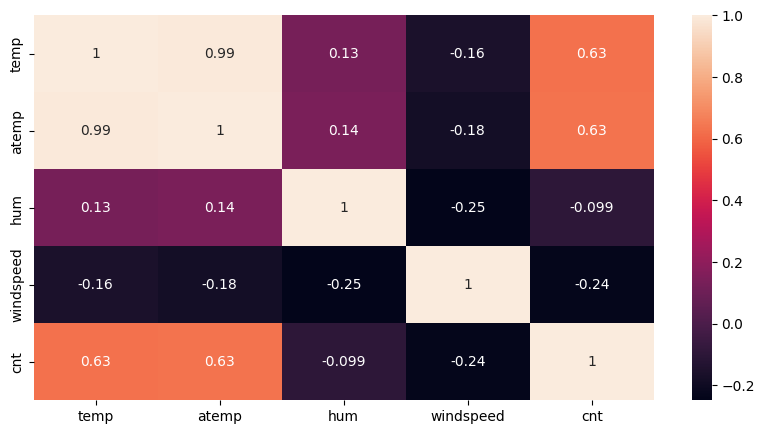

In [20]:
# Create heatmap to visualize the correllation matrix
plt.figure(figsize=(10,5))
sns.heatmap(corr,annot=True)
plt.show()

**Insights**

---


* Temp and atemp has a very high positive correlation, expecting them to measure similar things and potentially show multicollinearity issue. For modeling, we should use one of them only, we will drop atemp
* Temp is the strongest predictor with high positive correlation with number of bike users.
* Windspeed can provide independent information to the model and humidity might be less important due to weak correlation

In [21]:
# Drop atemp variable to prevent multicollinearity
df.drop(['atemp'], axis = 1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,1,Mist,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


## **Feature engineering / dummy variables**

**Create dummy variables for categorial data**

In [22]:
# Convert to dummy variables
df = pd.get_dummies(df, columns=['season', 'weathersit','weekday','mnth'], drop_first=True).astype(int)

In [23]:
# Check the data after creating dummy
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
0,0,0,1,14,80,10,985,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,1,14,69,16,801,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8,43,16,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8,59,10,1562,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9,43,12,1600,1,0,0,...,0,0,1,0,0,0,0,0,0,0


## **Split train/test data**

In [24]:
# Train-test split
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)
print(f'Train data:', df_train.shape)
print(f'Test data:', df_test.shape)

Train data: (510, 29)
Test data: (220, 29)


In [25]:
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
576,1,0,1,29,70,11,7216,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,16,62,10,4066,1,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,1,10,48,23,1796,1,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,15,48,8,4220,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,13,72,14,1683,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Create X_train, y_train
X_train = df_train.drop(['cnt'], axis=1)
y_train = df_train['cnt']

In [27]:
# Check the y_train data after splitting
y_train.head()

,cnt
576,7216
426,4066
728,1796
482,4220
111,1683


In [28]:
# Check the X_train data after splitting
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_Light Rain,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
576,1,0,1,29,70,11,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,16,62,10,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,1,10,48,23,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,15,48,8,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,13,72,14,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Feature scaling for numerical variables of the training data**

In [29]:
# Scale numerical features (temp, atemp, hum, windspeed)
from sklearn.preprocessing import StandardScaler

# Instantiate an object
scaler = StandardScaler()

# Fit on data
X_train[['temp','hum','windspeed']] = scaler.fit_transform(X_train[['temp','hum','windspeed']])

# Check the training data after scalling
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,weathersit_Light Rain,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
576,1,0,1,1.265366,0.520323,-0.252017,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,-0.486069,-0.045638,-0.441031,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,1,-1.294424,-1.036069,2.016140,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
482,1,0,0,-0.620795,-1.036069,-0.819057,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,-0.890247,0.661813,0.315022,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Step 3: Training the model**

**Build the model with SKlearn**

In [30]:
# Add a constant to the model
X_train_sm = sm.add_constant(X_train)

# Create the model
lr = sm.OLS(y_train, X_train_sm)

# Fit the model
lr_model = lr.fit()

# Check the parameters after fitting
lr_model.params

,0
const,4128.466731
yr,2005.364305
holiday,-1189.837533
workingday,-547.330580
temp,851.410840
hum,-198.590547
windspeed,-266.394936
season_spring,-373.469007
season_summer,382.204635
season_winter,956.607676


In [31]:
# Check the statiscal summary of the model
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.14
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          2.77e-178
Time:                        14:42:54   Log-Likelihood:                -4103.6
No. Observations:                 510   AIC:                             8265.
Df Residuals:                     481   BIC:                             8388.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4128.4667    676.758      6.100      0.000    2798.699    5458.234
yr                     2005.3643     70.932     28.272      0.000    1865.989    2144.739
holiday               -1189.8375    569.875     -2.088      0.037   -2309.591     -70.085
workingday             -547.3306    619.257     -0.884      0.377   -1764.113     669.452
temp                    851.4108     91.570      9.298      0.000     671.484    1031.337
hum                    -198.5905     49.423     -4.018      0.000    -295.702    -101.479
windspeed              -266.3949     38.473     -6.924      0.000    -341.991    -190.799
season_spring          -373.4690    263.070     -1.420      0.156    -890.378     143.440
season_summer           382.2046    229.279      1.667      0.096     -68.307     832.716
season_winter           956.6077    245.364      3.899      0.000     474.490    1438.725
weathersit_Light Rain -2185.7306    232.009     -9.421      0.000   -2641.607   -1729.855
weathersit_Mist        -506.2204     91.593     -5.527      0.000    -686.193    -326.248
weekday_Mon            -214.6279    127.059     -1.689      0.092    -464.287      35.032
weekday_Sat            -501.1479    624.120     -0.803      0.422   -1727.486     725.190
weekday_Sun            -453.3391    623.309     -0.727      0.467   -1678.083     771.405
weekday_Thu              43.3907    130.393      0.333      0.739    -212.819     299.601
weekday_Tue            -231.5799    127.928     -1.810      0.071    -482.946      19.786
weekday_Wed             -86.8665    133.016     -0.653      0.514    -348.230     174.497
mnth_Aug                231.4179    295.631      0.783      0.434    -349.469     812.305
mnth_Dec               -394.6039    295.021     -1.338      0.182    -974.294     185.086
mnth_Feb               -342.2542    289.766     -1.181      0.238    -911.617     227.109
mnth_Jan               -581.3626    294.582     -1.974      0.049   -1160.190      -2.535
mnth_Jul               -240.4432    307.655     -0.782      0.435    -844.957     364.071
mnth_Jun                 83.8228    217.684      0.385      0.700    -343.906     511.552
mnth_Mar                 11.5047    215.901      0.053      0.958    -412.721     435.730
mnth_May                216.8923    185.178      1.171      0.242    -146.965     580.749
mnth_Nov               -350.3142    319.438     -1.097      0.273    -977.981     277.353
mnth_Oct                 42.2421    315.389      0.134      0.894    -577.468     661.952
mnth_Sep                784.1249    280.446      2.796      0.005     233.074    1335.176
==============================================================================
Omnibus:                       79.508   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarqu

**Significance of variables**
* R-squared: 0.85, meaning that 85% change in bike demand can be explained by the model
* Some of the variables have high p-value (>0.05):

**We will check the VIF of variables **

In [33]:
# Check VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,38.41
6,season_spring,13.47
8,season_winter,12.42
7,season_summer,9.73
13,weekday_Sun,7.69
12,weekday_Sat,7.38
25,mnth_Nov,7.16
3,temp,7.03
26,mnth_Oct,6.68
17,mnth_Aug,6.43


**Dropping variables**

---

We can manually drop the variables following this order:

* Drop workingday (VIF=38.41, p=0.377) first as it has extremely high VIF and high p-value
* Drop season variables with high p-values & high VIF:
* - season_spring (VIF=13.47, p=0.156)
* - season_summer (VIF=9.73, p=0.096)

* Drop redundant weekday variables with high p-values & high VIF:
* - weekday_Sat (VIF=7.38, p=0.422)
* - weekday_Sun (VIF=7.69, p=0.467)

* Drop most month variables with high VIF and p-values:
* - mnth_Nov (VIF=7.16, p=0.273)
* - mnth_Oct (VIF=6.68, p=0.894)
* - mnth_Aug (VIF=6.43, p=0.434)
* - mnth_Dec (VIF=5.82, p=0.182)

**The quantity of variables that we need to drop quite alot, so we will use an automated approach to eliminate the features**



**Building the model with SKlearn and using RFE for automated feature selection**

In [34]:
# Create the model
sk_model = LinearRegression()

# Fit the model using fit()
sk_model.fit(X_train, y_train)

# Check the information of the model
print(sk_model.coef_)
print(sk_model.intercept_)

[ 2005.36430543 -1189.83753301  -547.33058021   851.41084012
  -198.5905468   -266.39493606  -373.46900714   382.20463537
   956.60767648 -2185.73060081  -506.22039614  -214.62793314
  -501.14794163  -453.33907991    43.3906861   -231.57994221
   -86.86648728   231.41793821  -394.60392393  -342.25418687
  -581.36259918  -240.44317782    83.8227981     11.50470357
   216.89230989  -350.31422285    42.24210142   784.12485691]
4128.466731258705


In [35]:
# Create RFE with 8 significant features
rfe = RFE(sk_model, n_features_to_select=8)
rfe = rfe.fit(X_train, y_train)

# Create a dataframe of features and their ranking (1 means selected)
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
    })

# Print feature ranking
feature_ranking = feature_ranking.sort_values('Ranking')
print(feature_ranking)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Create new X_train with selected features only
X_train_rfe = X_train[selected_features]

                  Feature  Selected  Ranking
0                      yr      True        1
21               mnth_Jul      True        1
10        weathersit_Mist      True        1
9   weathersit_Light Rain      True        1
6           season_spring      True        1
27               mnth_Sep      True        1
3                    temp      True        1
1                 holiday      True        1
8           season_winter     False        2
25               mnth_Nov     False        3
20               mnth_Jan     False        4
18               mnth_Dec     False        5
19               mnth_Feb     False        6
7           season_summer     False        7
5               windspeed     False        8
2              workingday     False        9
12            weekday_Sat     False       10
13            weekday_Sun     False       11
15            weekday_Tue     False       12
11            weekday_Mon     False       13
4                     hum     False       14
24        

In [36]:
X_train_rfe.head()

,yr,holiday,temp,season_spring,weathersit_Light Rain,weathersit_Mist,mnth_Jul,mnth_Sep
576,1,0,1.265366,0,0,0,1,0
426,1,0,-0.486069,1,0,1,0,0
728,1,0,-1.294424,1,0,0,0,0
482,1,0,-0.620795,0,0,1,0,0
111,0,0,-0.890247,0,0,1,0,0


**Build the model with selected features**

In [37]:
# Add a constant to the model
X_train_rfe_sm = sm.add_constant(X_train_rfe)

# Create and fit the model
model = sm.OLS(y_train, X_train_rfe_sm).fit()

# Check the parameters after fitting
model.params

,0
const,4107.338591
yr,2033.448489
holiday,-821.082015
temp,785.014876
season_spring,-1316.824296
weathersit_Light Rain,-2540.937951
weathersit_Mist,-690.124229
mnth_Jul,-601.209493
mnth_Sep,563.403489


In [38]:
# Check the statiscal information of the final model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     276.6
Date:                Tue, 04 Feb 2025   Prob (F-statistic):          2.25e-178
Time:                        14:45:03   Log-Likelihood:                -4156.0
No. Observations:                 510   AIC:                             8330.
Df Residuals:                     501   BIC:                             8368.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4107.3386     70.202     58.508      0.000    3969.413    4245.264
yr                     2033.4485     75.517     26.927      0.000    1885.079    2181.818
holiday                -821.0820    238.798     -3.438      0.001   -1290.251    -351.913
temp                    785.0149     53.199     14.756      0.000     680.494     889.536
season_spring         -1316.8243    111.265    -11.835      0.000   -1535.429   -1098.220
weathersit_Light Rain -2540.9380    225.107    -11.288      0.000   -2983.207   -2098.669
weathersit_Mist        -690.1242     80.317     -8.593      0.000    -847.924    -532.325
mnth_Jul               -601.2095    159.065     -3.780      0.000    -913.725    -288.694
mnth_Sep                563.4035    144.004      3.912      0.000     280.477     846.330
==============================================================================
Omnibus:                       56.292   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.864
Skew:                          -0.587   Prob(JB):                     1.41e-29
Kurtosis:                       5.208   Cond. No.                         7.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# Check VIF
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,2.00
3,season_spring,1.85
0,yr,1.44
6,mnth_Jul,1.32
5,weathersit_Mist,1.28
7,mnth_Sep,1.15
1,holiday,1.03
4,weathersit_Light Rain,1.02


**The model has small number of features with all low p-values and low VIF and a good R-squared of 0.81, so we will finalise this model and doing further evaluation**

# **Step 4: Residual Analysis**

In [40]:
# Create prediction of y_train
y_train_pred = model.predict(X_train_rfe_sm)

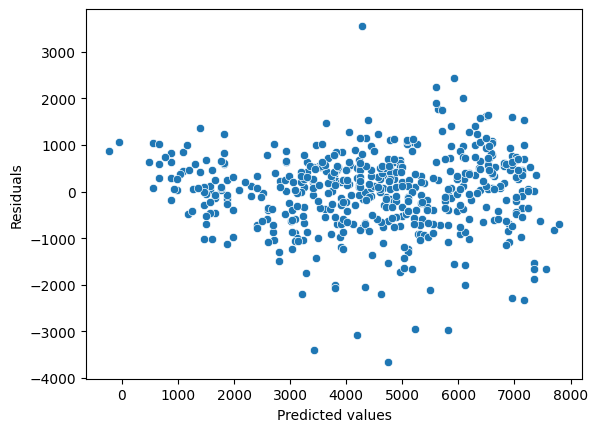

In [60]:
# Check the linearity assumption and homoscedasticity using a scatter plot of the predicted values and residual
res = y_train - y_train_pred
sns.scatterplot(x=y_train_pred, y=res)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

<Axes: ylabel='Density'>

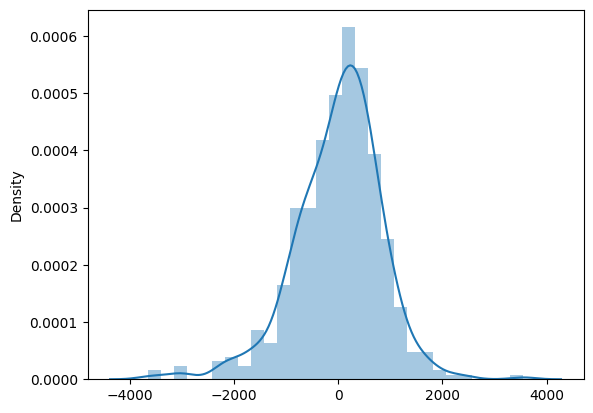

In [61]:
# Check the error assumption using the distribution plot of the residuals
sns.distplot(res)

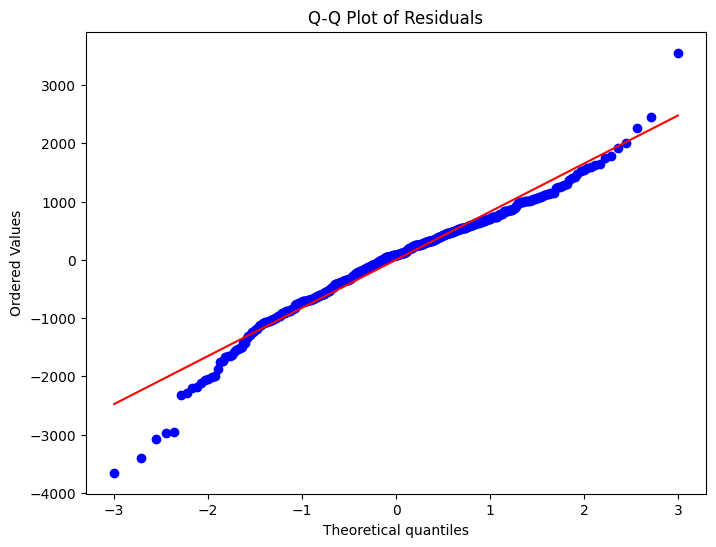

In [62]:
# Residuals have deviation at tails, we can use Q-Q plot to identify patterns of deviation
# Create Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(res, dist="norm", plot=ax)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [63]:
# Check the statistical independence of the errors using statistical test
# Perform Durbin_watson test
from statsmodels.stats.stattools import durbin_watson
durbin_watson(res)

2.054239737857305

**Analyzing the residuals, we can see that**
* Some outliers of residuals present.
* Distribution of residuals has bell-shaped, centered around 0, with some slight skewness
* Q-Q plot shows slight deviation from normality at extreme values
* Statiscal test support normality with durbin watson around 2

With large sample size, these deviations might not significant, suggesting that the model is unbiased or non-violating necessary assumptions of linear regression.

# **Step 5: Predictions and evaluation on the test set**

**Transformation on the test set**

In [64]:
# Create X_test, y_test
X_test = df_test.drop(['cnt'], axis=1)
y_test = df_test['cnt']

In [65]:
# Transform the X_test
X_test[['temp','hum','windspeed']] = scaler.transform(X_test[['temp','hum','windspeed']])

In [66]:
# Keeping only selected features
cols = X_train_rfe.columns
X_test = X_test[cols]

In [67]:
# add a constant
X_test_sm = sm.add_constant(X_test)

In [68]:
# Checking the test data after tranforming, dropping variables and adding constant
X_test_sm.head()

,const,yr,holiday,temp,season_spring,weathersit_Light Rain,weathersit_Mist,mnth_Jul,mnth_Sep
184,1.0,0,1,1.265366,0,0,1,1,0
535,1.0,1,0,1.669543,0,0,0,0,0
299,1.0,0,0,-0.081892,0,0,1,0,0
221,1.0,0,0,1.534817,0,0,0,0,0
152,1.0,0,0,1.265366,0,0,0,0,0


**Prediction and evaluation**

In [69]:
# Make prediction
y_test_pred = model.predict(X_test_sm)

In [70]:
# Evaluate the model
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8002033344275925

**Evaluation:**

---
**R2-squared of the test set of 0.8 is very close to 0.81 of the train set. Small gap indicates good generalization of the model**
